In [1]:
import os
import time
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ivolatility as ivol

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

from nelson_siegel_svensson.calibrate import calibrate_nss_ols

## Variance Gamma Model

In [3]:
def vg_charfunc(phi, S0, theta, sigma, nu, tau, r):
    """
    Variance Gamma characteristic function of ln(S_tau).
    
    ----------
    Parameters
    phi   : float or ndarray
        Frequency argument of the characteristic function.
    S0    : float
        Spot price at t=0.
    theta : float
        'Drift' parameter of the VG subordinator (sometimes denoted as θ).
    sigma : float
        'Vol' parameter of the VG subordinator.
    nu    : float
        'Gamma' parameter (sometimes 1/kappa in other notations).
    tau   : float
        Time to maturity (T - 0).
    r     : float
        Risk-free interest rate.
    -------
    Notes
    The key difference from Heston is the explicit "martingale adjustment" ω:
        ω = - (1/nu) * ln(1 - theta*nu - 0.5*sigma^2 * nu)
    so that discounted S_t is a martingale under the risk-neutral measure.
    -----
    """
    # Martingale adjustment: ensure E[e^{-r tau} * S_tau] = S_0
    omega = -(1.0 / nu) * np.log(1.0 - theta*nu - 0.5*sigma**2 * nu)
    
    # VG characteristic function for ln(S_tau):
    #   exp{ i φ [ ln(S0) + (r + ω)*τ ] } * (1 - i θ ν φ + 0.5 σ^2 ν φ^2)^(-τ/ν)
    return np.exp(
        1j * phi * (np.log(S0) + (r + omega) * tau)
    ) * (
        (1.0 - 1j * theta * nu * phi + 0.5 * (sigma ** 2) * nu * (phi ** 2)) ** (-tau / nu)
    )


def integrand_vg(phi, S0, K, theta, sigma, nu, tau, r):
    """
    Parameters
    phi   : float
        Integration variable (Fourier frequency).
    S0, K : float
        Spot (S0) and strike (K).
    theta, sigma, nu, tau, r : float
        VG parameters and maturity/rate.
    """
    numerator = (
        np.exp(1j * phi * r * tau) * vg_charfunc(phi - 1j, S0, theta, sigma, nu, tau, r)
        - K * vg_charfunc(phi, S0, theta, sigma, nu, tau, r)
    )
    denominator = 1j * phi * (1j * phi + 1.0)
    
    return numerator / denominator


def vg_price_rec(S0, K, theta, sigma, nu, tau, r):
    """
    Parameters
    S0, K : float
        Spot and strike.
    theta, sigma, nu : float
        VG parameters.
    tau   : float
        Time to maturity.
    r     : float
        Risk-free interest rate.
    """
   
    phi_max = 100.0
    N = 10000
    dphi = phi_max / N
    
    P = 0.0
    for i in range(1, N):
        # midpoint in each subinterval (rectangular rule)
        phi = dphi * (2 * i - 1) / 2.0
        P += dphi * integrand_vg(phi, S0, K, theta, sigma, nu, tau, r)
    
    return np.real( (S0 - K * np.exp(-r * tau)) / 2.0 + P / np.pi )

## Kou Model

In [4]:
# --- Step 1: Kou Characteristic Function ---
def kou_charfunc(phi, S0, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Characteristic function for the Kou Double Exponential Jump Model.
    """
    drift = r - 0.5 * sigma**2 - lambd * (p * eta1 / (eta1 + 1) + (1 - p) * eta2 / (eta2 + 1) - 1)
    exp1 = np.exp(1j * phi * (np.log(S0) + drift * tau))
    diffusion = -0.5 * sigma**2 * phi**2 * tau
    jumps = lambd * tau * (
        p * eta1 / (eta1 - 1j * phi) + (1 - p) * eta2 / (eta2 + 1j * phi) - 1
    )
    return exp1 * np.exp(diffusion + jumps)

# --- Step 2: Integrand for Numerical Integration ---
def integrand_kou(phi, S0, sigma, lambd, p, eta1, eta2, tau, r, K):
    """
    Integrand for numerical integration in the Kou model.
    """
    args = (S0, sigma, lambd, p, eta1, eta2, tau, r)
    numerator = np.exp(r * tau) * kou_charfunc(phi - 1j, *args) - K * kou_charfunc(phi, *args)
    denominator = 1j * phi * K**(1j * phi)
    return numerator / denominator

# --- Step 3: Rectangular Numerical Integration ---
def kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Option price using rectangular integration for the Kou model.
    """
    args = (S0, sigma, lambd, p, eta1, eta2, tau, r)
    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(r * tau) * kou_charfunc(phi - 1j, *args) - K * kou_charfunc(phi, *args)
        denominator = 1j * phi * K**(1j * phi)
        P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# --- Step 4: Option Price Using Scipy Quad Integration ---
def kou_price(S0, K, sigma, lambd, p, eta1, eta2, tau, r):
    """
    Option price using scipy quad integration for the Kou model.
    """
    real_integral, err = np.real(quad(integrand_kou, 0, 100, args=(S0, sigma, lambd, p, eta1, eta2, tau, r, K)))
    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi

## Merton Jump Model

In [5]:
# --- Part 1: Merton Characteristic Function ---
def merton_charfunc(phi, S0, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Characteristic function for the Merton Jump Diffusion Model.
    """
    drift = r - 0.5 * sigma**2 - lambd * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
    exp1 = np.exp(1j * phi * (np.log(S0) + drift * tau))
    diffusion = -0.5 * sigma**2 * phi**2 * tau
    jumps = lambd * tau * (np.exp(1j * phi * mu_j - 0.5 * sigma_j**2 * phi**2) - 1)
    return exp1 * np.exp(diffusion + jumps)

# --- Part 2: Integrand for Numerical Integration ---
def integrand_merton(phi, S0, sigma, lambd, mu_j, sigma_j, tau, r, K):
    """
    Integrand for numerical integration in the Merton Jump Diffusion Model.
    """
    args = (S0, sigma, lambd, mu_j, sigma_j, tau, r)
    numerator = np.exp(r * tau) * merton_charfunc(phi - 1j, *args) - K * merton_charfunc(phi, *args)
    denominator = 1j * phi * K**(1j * phi)
    return numerator / denominator

# --- Part 3: Rectangular Numerical Integration ---
def merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Option price using rectangular integration for the Merton Jump Diffusion Model.
    """
    args = (S0, sigma, lambd, mu_j, sigma_j, tau, r)
    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(r * tau) * merton_charfunc(phi - 1j, *args) - K * merton_charfunc(phi, *args)
        denominator = 1j * phi * K**(1j * phi)
        P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# --- Part 4: Option Price Using Scipy Quad Integration ---
def merton_price(S0, K, sigma, lambd, mu_j, sigma_j, tau, r):
    """
    Option price using scipy quad integration for the Merton Jump Diffusion Model.
    """
    real_integral, err = np.real(quad(integrand_merton, 0, 100, args=(S0, sigma, lambd, mu_j, sigma_j, tau, r, K)))
    return (S0 - K * np.exp(-r * tau)) / 2 + real_integral / np.pi


## Heston Model

In [6]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2


def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator


def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax / N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)


def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

## Set up and Get Data

In [9]:
username = 'PutYourIVolatilityUSernameHere'
password = 'PutYourPasswordHere'

In [10]:
# loginto the IVol account
ivol.setLoginParams(username=username, password=password)

In [7]:
# Define the parameters for the options
# If the relative data is already present in the data folder, load it from there instead of querying the IVol API
symbol =            'UCG'
tradeDate =         '2024-10-04'
last_trade_date =   '2024-10-09'
region =            'EUROPE'
dteFrom =           10
dteTo =             1000
cp =                'C'
deltaFrom =         0
deltaTo =           1

In [8]:
p = f'../data/{symbol}_{region}_{tradeDate}_dteFrom{dteFrom}-To{dteTo}_cp{cp}_deltaFrom{deltaFrom}-To{deltaTo}.csv'
p

'../data/UCG_EUROPE_2024-10-04_dteFrom10-To1000_cpC_deltaFrom0-To1.csv'

In [9]:
if not os.path.exists(p):
    getMarketData = ivol.setMethod('/equities/eod/stock-opts-by-param')
    marketData = getMarketData(symbol=symbol, tradeDate=tradeDate, dteFrom=dteFrom, dteTo=dteTo, cp='C', deltaFrom=deltaFrom, deltaTo=deltaTo, region=region)
    marketData.to_csv(p)
else:
    marketData = pd.read_csv(p)
marketData

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,preiv,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id
0,2024-10-04 00:00:00.0,1UCG 241004C00000320000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,32.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-17.57,NaN
1,2024-10-04 00:00:00.0,1UCG 241004C00000325000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,32.5,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-16.28,NaN
2,2024-10-04 00:00:00.0,1UCG 241004C00000330000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,33.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-14.99,NaN
3,2024-10-04 00:00:00.0,1UCG 241004C00000335000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,33.5,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-13.70,NaN
4,2024-10-04 00:00:00.0,1UCG 241004C00000340000A.XMIL,0,19123,2024-10-04 00:00:00.0,C,34.0,0.0,0.0,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.001,0.001,38.82,-12.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2024-10-04 00:00:00.0,UCG 270618C00000960000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,96.0,0.0,0.0,0.0,...,0.267132,0.003354,-0.000404,0.027316,0.016001,0.001,0.001,38.82,147.30,NaN
549,2024-10-04 00:00:00.0,UCG 270618C00001000000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,100.0,0.0,0.0,0.0,...,0.268345,0.002819,-0.000341,0.023059,0.013151,0.001,0.001,38.82,157.60,NaN
550,2024-10-04 00:00:00.0,UCG 270618C00001040000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,104.0,0.0,0.0,0.0,...,0.267728,0.002298,-0.000277,0.018758,0.010388,0.001,0.001,38.82,167.90,NaN
551,2024-10-04 00:00:00.0,UCG 270618C00001080000A.XMIL,987,19123,2027-06-18 00:00:00.0,C,108.0,0.0,0.0,0.0,...,0.267938,0.001901,-0.000229,0.015528,0.008382,0.001,0.001,38.82,178.21,NaN


In [10]:
marketData.columns

Index(['c_date', 'option_symbol', 'dte', 'stocks_id', 'expiration_date',
       'call_put', 'price_strike', 'price_open', 'price_high', 'price_low',
       'price', 'volume', 'openinterest', 'iv', 'delta', 'preiv', 'gamma',
       'theta', 'vega', 'rho', 'Ask', 'Bid', 'underlying_price', 'calc_OTM',
       'option_id'],
      dtype='object')

In [11]:
marketData['price'].describe()

count    553.000000
mean      13.659486
std       13.833844
min        0.000100
25%        0.353600
50%        7.924800
75%       28.845300
max       37.027700
Name: price, dtype: float64

### Compute strikes and maturities

In [12]:
def calc_maturity(date):
    #invece che today mettere a data desiderata vecchia, per non avere maturities negative
    return ((dt.strptime(date, '%Y-%m-%d %H:%M:%S.%f') - dt.today()).days / 365.25)

In [13]:
all_strikes = [date_group['price_strike'].tolist() for date, date_group in marketData.groupby('expiration_date')]
common_strikes = sorted(set.intersection(*map(set, all_strikes)))

In [14]:
num_exp_days = marketData['expiration_date'].unique().shape[0]
print(f"Number of expiration days: {num_exp_days} - number of common strikes: {len(common_strikes)}")

Number of expiration days: 12 - number of common strikes: 6


In [15]:
maturities = []
all_prices = []

for date, date_group in marketData.groupby('expiration_date'):
    maturities.append(calc_maturity(date))
    # prices = date_group[date_group['price_strike'].isin(common_strikes)]['price'].tolist()
    prices = [date_group['price'].tolist()[i] for i,x in enumerate(date_group['price_strike'].tolist()) if x in common_strikes][:len(common_strikes)]
    all_prices.append(prices)

price_arr = np.array(all_prices)
price_arr.shape

(12, 6)

### Compute volatility surface

In [16]:
vol_surface = pd.DataFrame(price_arr, index=maturities, columns=common_strikes)
vol_surface

,34.0,36.0,38.0,40.0,44.0,48.0
-0.276523,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010
-0.257358,4.8450,2.8888,1.1265,0.1859,0.0003,0.0010
-0.238193,4.9290,3.0438,1.4198,0.4322,0.0189,0.0002
-0.161533,5.3502,3.6499,2.2666,1.2374,0.2726,0.0437
-0.065708,5.4525,3.8561,2.4916,1.4956,0.4435,0.1284
0.183436,6.0207,4.5976,3.3957,2.4294,1.1324,0.4864
0.432580,6.3252,4.9928,3.8220,2.8566,1.5202,0.7532
0.681725,6.6299,5.3485,4.2329,3.3003,1.9405,1.1129
0.930869,6.9528,5.7198,4.6639,3.7497,2.3922,1.4838
1.429158,7.0144,5.8329,4.8055,3.9439,2.6551,1.8221


In [17]:
vol_surface_long = vol_surface.melt(ignore_index=False).reset_index()
vol_surface_long.columns = ['maturity', 'strike', 'price']
vol_surface_long

,maturity,strike,price
0,-0.276523,34.0,0.0010
1,-0.257358,34.0,4.8450
2,-0.238193,34.0,4.9290
3,-0.161533,34.0,5.3502
4,-0.065708,34.0,5.4525
...,...,...,...
67,0.681725,48.0,1.1129
68,0.930869,48.0,1.4838
69,1.429158,48.0,1.8221
70,1.927447,48.0,2.2106


In [18]:
# Put there the correct values
yield_maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([4.93, 4.84, 4.75, 4.65, 4.46, 4.24, 3.99, 3.89, 3.91, 3.97, 4.06, 4.41, 4.34]).astype(float) / 100

In [19]:
# NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities, yeilds)
curve_fit

NelsonSiegelSvenssonCurve(beta0=np.float64(0.044103308774897605), beta1=np.float64(0.005354152287744192), beta2=np.float64(-0.03515848351569766), beta3=np.float64(0.009899518690519308), tau1=np.float64(2.0), tau2=np.float64(5.0))

In [20]:
vol_surface_long['rate'] = vol_surface_long['maturity'].apply(curve_fit)
vol_surface_long

,maturity,strike,price,rate
0,-0.276523,34.0,0.0010,0.049457
1,-0.257358,34.0,4.8450,0.049457
2,-0.238193,34.0,4.9290,0.049457
3,-0.161533,34.0,5.3502,0.049457
4,-0.065708,34.0,5.4525,0.049457
...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467
68,0.930869,48.0,1.4838,0.043163
69,1.429158,48.0,1.8221,0.041185
70,1.927447,48.0,2.2106,0.039868


## Apply Models

In [21]:
def get_last_trade_price(symbol, date, region=region):
    """Get the last trade price. Requires an active IVol account """
    getMarketData_stocks = ivol.setMethod('/equities/eod/stock-prices')
    marketData_stocks = getMarketData_stocks(symbol=symbol, date=date, region=region)
    return float(marketData_stocks['close'].iloc[0])

In [22]:
def callback(*args):
    global iteration, start, prev, stat
    if iteration == 0:
        print('#iterations\tstep time (s)\ttotal time (s)')
    step = round(time.time() - prev, 3)
    total = round(time.time() - start, 3)
    print(f'{iteration}\t\t{step}\t\t{total}')
    prev = time.time()
    stat.append([iteration, step, total])
    iteration += 1

In [72]:
def plot_time_stat(model_name, stat):
    _, steps, totals = zip(*stat)
    plt.plot(steps,     label=f'{model_name}-step time (s)')
    plt.plot(totals,    label=f'{model_name}-cumulative time (s)')
    plt.legend()
    plt.xlabel('iteration')
    plt.ylabel('time (s)')

In [25]:
# General parameters used in the optimization process
method = 'Nelder-Mead'
max_iter = 1e1

# put real data there using the function get_last_trade_price defined above 
last_trade_price = 100 

### Apply the Heston Model

In [ ]:
# Define variables to be used in optimization
S0 =    last_trade_price # get_last_trade_price(symbol, last_trade_date)
r =     vol_surface_long['rate'].to_numpy('float')
K =     vol_surface_long['strike'].to_numpy('float')
tau =   vol_surface_long['maturity'].to_numpy('float')
P =     vol_surface_long['price'].to_numpy('float')

params = {
    "v0"    : {"x0": 0.1,   "lbub": [1e-3,  0.1]},
    "kappa" : {"x0": 3,     "lbub": [1e-3,  5]},
    "theta" : {"x0": 0.05,  "lbub": [1e-3,  0.1]},
    "sigma" : {"x0": 0.3,   "lbub": [1e-2,  1]},
    "rho"   : {"x0": -0.8,  "lbub": [-1,    0]},
    "lambd" : {"x0": 0.03,  "lbub": [-1,    1]},
}

x0 =    [param["x0"]    for key, param in params.items()]
bnds =  [param["lbub"]  for key, param in params.items()]
iter = 0

In [27]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd

def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]

    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])

    # Decided to use rectangular integration function in the end
    err = np.sum( (P - heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )

    # Zero penalty term - no good guesses for parameters
    pen = 0 # np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

    return err + pen

start = time.time()
prev = time.time()
iteration = 0
stat = heston_stat = []

result = minimize(SqErr, x0, tol=1e-3, method=method, options={'maxiter': max_iter}, bounds=bnds, callback=callback)

#iterations	step time (s)	total time (s)
0		10.611		10.611
1		1.362		11.973
2		2.717		14.69
3		1.393		16.083
4		2.765		18.849
5		2.581		21.429
6		1.281		22.711
7		2.623		25.334
8		2.848		28.182


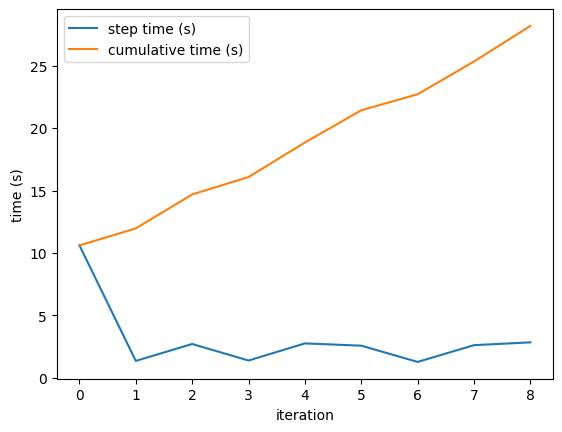

In [28]:
plot_time_stat(heston_stat)

In [29]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 530552280.8656082
             x: [ 7.931e-02  2.450e+00  5.347e-02  3.471e-01 -8.556e-01
                  2.771e-02]
           nit: 10
          nfev: 21
 final_simplex: (array([[ 7.931e-02,  2.450e+00, ..., -8.556e-01,
                         2.771e-02],
                       [ 8.083e-02,  2.700e+00, ..., -8.133e-01,
                         3.025e-02],
                       ...,
                       [ 9.556e-02,  2.900e+00, ..., -8.356e-01,
                         2.958e-02],
                       [ 9.556e-02,  2.900e+00, ..., -8.356e-01,
                         2.958e-02]]), array([ 5.306e+08,  1.812e+10,  2.934e+11,  3.210e+11,
                        1.559e+12,  5.696e+12,  6.893e+12]))

In [30]:
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
print(f"v0={v0}, kappa={kappa}, theta={theta}, sigma={sigma}, rho={rho}, lambda={lambd}")

v0=0.07930555555555524, kappa=2.450000000000001, theta=0.05347222222222206, sigma=0.34708333333333374, rho=-0.8555555555555538, lambda=0.02770833333333335


In [31]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
vol_surface_long['heston_price'] = heston_prices
vol_surface_long

,maturity,strike,price,rate,heston_price
0,-0.276523,34.0,0.0010,0.049457,155.949751
1,-0.257358,34.0,4.8450,0.049457,743.252596
2,-0.238193,34.0,4.9290,0.049457,1418.516903
3,-0.161533,34.0,5.3502,0.049457,-1944.364622
4,-0.065708,34.0,5.4525,0.049457,-88707.637782
...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.713529
68,0.930869,48.0,1.4838,0.043163,57.034634
69,1.429158,48.0,1.8221,0.041185,59.813516
70,1.927447,48.0,2.2106,0.039868,61.343016


In [32]:
vol_surface_long['heston_difference'] = vol_surface_long['price'] - vol_surface_long['heston_price']
vol_surface_long['heston_difference'].describe()

count        72.000000
mean        855.670179
std       23179.352115
min     -100967.353265
25%         -68.756557
50%         -62.053806
75%         -56.531650
max       88713.090282
Name: heston_difference, dtype: float64

### Apply the Merton Jump Model

In [33]:
S0 =    last_trade_price  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

params = {
    "sigma"     : {"x0": 0.2, "lbub": [1e-2, 1]},
    "lambd"     : {"x0": 0.1, "lbub": [1e-3, 1]},
    "mu_j"      : {"x0": 0,   "lbub": [-1, 1]},
    "sigma_j"   : {"x0": 0.1, "lbub": [1e-2, 1]},
}

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

In [34]:
def SqErr_merton(x):
    sigma, lambd, mu_j, sigma_j = x
    return np.sum((P - merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r))**2 / len(P))

In [35]:
start = time.time()
prev = time.time()
iteration = 0
stat = merton_stat = []

result = minimize(SqErr_merton, x0, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		4.375		4.375
1		0.596		4.971
2		0.649		5.62
3		1.219		6.84
4		1.184		8.024
5		0.648		8.673
6		1.176		9.849
7		1.176		11.026
8		0.6		11.625


In [36]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 3543.873757916689
             x: [ 5.868e-02  1.047e-01  5.489e-04  1.213e-01]
           nit: 10
          nfev: 19
 final_simplex: (array([[ 5.868e-02,  1.047e-01,  5.489e-04,  1.213e-01],
                       [ 5.909e-02,  1.094e-01,  8.142e-04,  1.218e-01],
                       ...,
                       [ 1.409e-01,  1.012e-01,  5.889e-04,  1.094e-01],
                       [ 1.461e-01,  1.061e-01,  3.589e-04,  1.044e-01]]), array([ 3.544e+03,  3.545e+03,  4.342e+10,  1.603e+21,
                        9.526e+22]))

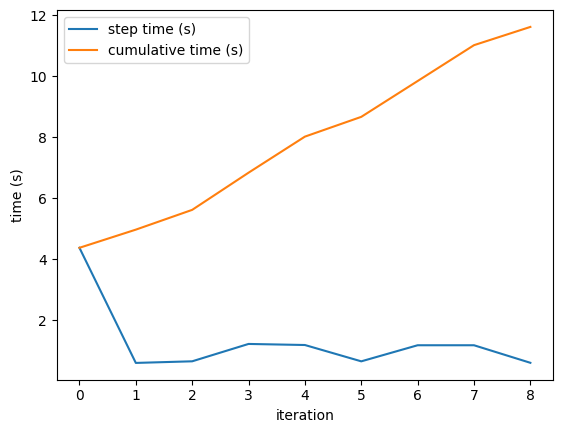

In [37]:
plot_time_stat(merton_stat)

In [38]:
sigma, lambd, mu_j, sigma_j = result.x
print(f"Calibrated parameters: sigma={sigma}, lambd={lambd}, mu_j={mu_j}, sigma_j={sigma_j}")

# --- Part 8: Final Volatility Surface and Comparison ---
merton_prices = merton_price_rec(S0, K, sigma, lambd, mu_j, sigma_j, tau, r)
vol_surface_long['merton_price'] = merton_prices
vol_surface_long['merton_difference'] = vol_surface_long['price'] - vol_surface_long['merton_price']
vol_surface_long['merton_difference'].describe()

Calibrated parameters: sigma=0.05868164062500025, lambd=0.1047149658203127, mu_j=0.0005488586425781249, sigma_j=0.12130432128906254


count    72.000000
mean    -59.011495
std       7.898333
min     -75.795340
25%     -63.727297
50%     -59.956505
75%     -55.267994
max     -39.451913
Name: merton_difference, dtype: float64

In [39]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.584303,40.000000,2.972253,0.045743,-852.697926,855.670179,61.983748,-59.011495
std,0.887791,4.794363,2.264968,0.003923,23179.054411,23179.352115,9.040801,7.898333
min,-0.276523,34.000000,0.000200,0.039040,-88707.637782,-100967.353265,39.452913,-75.795340
25%,-0.180698,36.000000,1.022975,0.042668,57.982876,-68.756557,56.616995,-63.727297
50%,0.308008,39.000000,2.872700,0.046953,66.748704,-62.053806,63.279487,-59.956505
75%,1.055441,44.000000,4.866000,0.049457,75.806955,-56.531650,68.477480,-55.267994
max,2.425736,48.000000,7.215400,0.049457,100967.481665,88713.090282,77.634973,-39.451913


### Kou Model

In [48]:
S0 =    last_trade_price  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

params = {
    "sigma" : {"x0": 0.2,   "lbub": [1e-2, 1]},
    "lambd" : {"x0": 0.1,   "lbub": [1e-3, 1]},
    "p"     : {"x0": 0.5,   "lbub": [0.01, 0.99]},
    "eta1"  : {"x0": 10,    "lbub": [1, 20]},
    "eta2"  : {"x0": 10,    "lbub": [1, 20]},
}

In [49]:
def SqErr(x):
    sigma, lambd, p, eta1, eta2 = x
    return np.sum((P - kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r))**2 / len(P))

In [50]:
iteration = 0
start = time.time()
prev = time.time()
stat = kou_stat = []

result = minimize(SqErr, x0, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		5.086		5.086
1		0.628		5.713
2		0.623		6.337
3		0.619		6.955
4		1.239		8.194
5		1.342		9.536
6		0.735		10.272
7		1.234		11.506
8		0.623		12.129


In [51]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 2236082250089448.5
             x: [ 1.226e-01  1.158e-01  5.338e-01  1.130e+01  1.029e+01]
           nit: 10
          nfev: 19
 final_simplex: (array([[ 1.226e-01,  1.158e-01, ...,  1.130e+01,
                         1.029e+01],
                       [ 1.245e-01,  1.141e-01, ...,  1.085e+01,
                         1.033e+01],
                       ...,
                       [ 1.671e-01,  1.132e-01, ...,  1.031e+01,
                         9.906e+00],
                       [ 1.800e-01,  1.030e-01, ...,  1.030e+01,
                         1.030e+01]]), array([ 2.236e+15,  7.910e+15,  2.114e+23,  1.285e+26,
                        5.828e+30,  1.418e+36]))

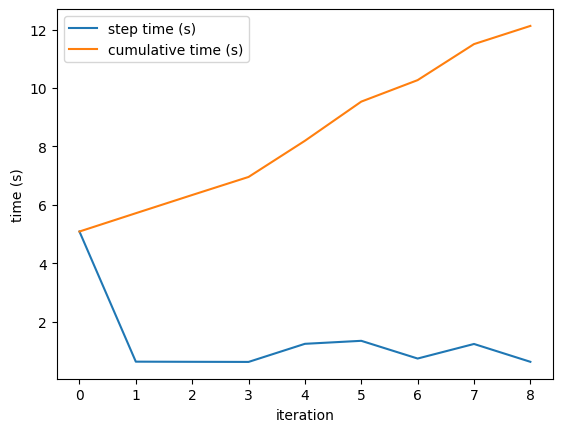

In [52]:
plot_time_stat(kou_stat)

In [53]:
sigma, lambd, p, eta1, eta2 = result.x
print(f"Calibrated parameters: sigma={sigma}, lambd={lambd}, p={p}, eta1={eta1}, eta2={eta2}")

# --- Step 8: Final Volatility Surface and Comparison ---
kou_prices = kou_price_rec(S0, K, sigma, lambd, p, eta1, eta2, tau, r)
vol_surface_long['kou_price'] = kou_prices
vol_surface_long['kou_difference'] = vol_surface_long['price'] - vol_surface_long['kou_price']
vol_surface_long

Calibrated parameters: sigma=0.12262604799999999, lambd=0.1158295808, p=0.533787904, eta1=11.302286079999988, eta2=10.293217279999986


,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference
0,-0.276523,34.0,0.0010,0.049457,155.949751,-155.948751,42.421949,-42.420949,-1.693325e+08,1.693325e+08
1,-0.257358,34.0,4.8450,0.049457,743.252596,-738.407596,48.272322,-43.427322,-4.315517e+07,4.315518e+07
2,-0.238193,34.0,4.9290,0.049457,1418.516903,-1413.587903,52.717038,-47.788038,-1.080415e+07,1.080415e+07
3,-0.161533,34.0,5.3502,0.049457,-1944.364622,1949.714822,61.818784,-56.468584,-3.649502e+04,3.650037e+04
4,-0.065708,34.0,5.4525,0.049457,-88707.637782,88713.090282,64.949591,-59.497091,4.382147e+01,-3.836897e+01
...,...,...,...,...,...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.713529,-54.600629,55.699300,-54.586400,5.609486e+01,-5.498196e+01
68,0.930869,48.0,1.4838,0.043163,57.034634,-55.550834,56.978992,-55.495192,5.753057e+01,-5.604677e+01
69,1.429158,48.0,1.8221,0.041185,59.813516,-57.991416,59.453756,-57.631656,6.033503e+01,-5.851293e+01
70,1.927447,48.0,2.2106,0.039868,61.343016,-59.132416,61.901916,-59.691316,6.313708e+01,-6.092648e+01


In [54]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,7.200000e+01,7.200000e+01
mean,0.584303,40.000000,2.972253,0.045743,-852.697926,855.670179,61.983748,-59.011495,-5.378218e+06,5.378221e+06
std,0.887791,4.794363,2.264968,0.003923,23179.054411,23179.352115,9.040801,7.898333,4.731008e+07,4.731008e+07
min,-0.276523,34.000000,0.000200,0.039040,-88707.637782,-100967.353265,39.452913,-75.795340,-2.128560e+08,-2.065671e+08
25%,-0.180698,36.000000,1.022975,0.042668,57.982876,-68.756557,56.616995,-63.727297,5.075806e+01,-6.699189e+01
50%,0.308008,39.000000,2.872700,0.046953,66.748704,-62.053806,63.279487,-59.956505,6.512090e+01,-6.116925e+01
75%,1.055441,44.000000,4.866000,0.049457,75.806955,-56.531650,68.477480,-55.267994,7.290637e+01,-4.716763e+01
max,2.425736,48.000000,7.215400,0.049457,100967.481665,88713.090282,77.634973,-39.451913,2.065671e+08,2.128560e+08


### Variance Gamma Model

In [60]:
S0 =    last_trade_price  # Replace with real market data
r =     vol_surface_long['rate'].to_numpy(float)
K =     vol_surface_long['strike'].to_numpy(float)
tau =   vol_surface_long['maturity'].to_numpy(float)
P =     vol_surface_long['price'].to_numpy(float)

x0 =    [param["x0"]    for param in params.values()]
bnds =  [param["lbub"]  for param in params.values()]

params = {
    "sigma"     : {"x0": 0.2, "lbub": [1e-2, 1]},
    "nu"        : {"x0": 0.1, "lbub": [1e-2, 1]}
}

In [61]:
def SqErr(x):
    sigma, nu = x
    return np.sum((P - vg_price_rec(S0, K, theta, sigma, nu, tau, r))**2 / len(P))

In [71]:
iteration = 0
start = time.time()
prev = time.time()
stat = vg_stat = []

result = minimize(SqErr, x0, bounds=bnds, method=method, options={'maxiter': max_iter}, callback=callback)

#iterations	step time (s)	total time (s)
0		2.848		2.848
1		1.202		4.05
2		1.186		5.236
3		1.098		6.334
4		1.126		7.46
5		1.228		8.687
6		1.226		9.914
7		1.154		11.068
8		1.435		12.504


In [63]:
result

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 3883.755880754278
             x: [ 1.000e-02  8.648e-02]
           nit: 10
          nfev: 21
 final_simplex: (array([[ 1.000e-02,  8.648e-02],
                       [ 1.000e-02,  1.066e-01],
                       [ 1.000e-02,  1.205e-01]]), array([ 3.884e+03,  3.884e+03,  3.884e+03]))

In [66]:
sigma, nu = result.x
print(f"Calibrated parameters: {sigma=}, {nu=}")

# --- Step 8: Final Volatility Surface and Comparison ---
vg_prices = vg_price_rec(S0, K, theta, sigma, nu, tau, r)
vol_surface_long['vg_price'] = vg_prices
vol_surface_long['vg_difference'] = vol_surface_long['price'] - vol_surface_long['vg_price']
vol_surface_long

Calibrated parameters: sigma=np.float64(0.01), nu=np.float64(0.08648437499999972)


,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference,vg_price,vg_difference
0,-0.276523,34.0,0.0010,0.049457,155.949751,-155.948751,42.421949,-42.420949,-1.693325e+08,1.693325e+08,62.985371,-62.984371
1,-0.257358,34.0,4.8450,0.049457,743.252596,-738.407596,48.272322,-43.427322,-4.315517e+07,4.315518e+07,63.145957,-58.300957
2,-0.238193,34.0,4.9290,0.049457,1418.516903,-1413.587903,52.717038,-47.788038,-1.080415e+07,1.080415e+07,63.307003,-58.378003
3,-0.161533,34.0,5.3502,0.049457,-1944.364622,1949.714822,61.818784,-56.468584,-3.649502e+04,3.650037e+04,63.954878,-58.604678
4,-0.065708,34.0,5.4525,0.049457,-88707.637782,88713.090282,64.949591,-59.497091,4.382147e+01,-3.836897e+01,64.772409,-59.319909
...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.681725,48.0,1.1129,0.044467,55.713529,-54.600629,55.699300,-54.586400,5.609486e+01,-5.498196e+01,57.629127,-56.516227
68,0.930869,48.0,1.4838,0.043163,57.034634,-55.550834,56.978992,-55.495192,5.753057e+01,-5.604677e+01,59.918735,-58.434935
69,1.429158,48.0,1.8221,0.041185,59.813516,-57.991416,59.453756,-57.631656,6.033503e+01,-5.851293e+01,64.637111,-62.815011
70,1.927447,48.0,2.2106,0.039868,61.343016,-59.132416,61.901916,-59.691316,6.313708e+01,-6.092648e+01,69.608962,-67.398362


In [67]:
vol_surface_long.describe()

,maturity,strike,price,rate,heston_price,heston_difference,merton_price,merton_difference,kou_price,kou_difference,vg_price,vg_difference
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,7.200000e+01,7.200000e+01,72.000000,72.000000
mean,0.584303,40.000000,2.972253,0.045743,-852.697926,855.670179,61.983748,-59.011495,-5.378218e+06,5.378221e+06,64.814165,-61.841912
std,0.887791,4.794363,2.264968,0.003923,23179.054411,23179.352115,9.040801,7.898333,4.731008e+07,4.731008e+07,9.500750,7.756901
min,-0.276523,34.000000,0.000200,0.039040,-88707.637782,-100967.353265,39.452913,-75.795340,-2.128560e+08,-2.065671e+08,49.035065,-80.969049
25%,-0.180698,36.000000,1.022975,0.042668,57.982876,-68.756557,56.616995,-63.727297,5.075806e+01,-6.699189e+01,58.615552,-65.841061
50%,0.308008,39.000000,2.872700,0.046953,66.748704,-62.053806,63.279487,-59.956505,6.512090e+01,-6.116925e+01,63.181651,-59.592624
75%,1.055441,44.000000,4.866000,0.049457,75.806955,-56.531650,68.477480,-55.267994,7.290637e+01,-4.716763e+01,70.049609,-57.247190
max,2.425736,48.000000,7.215400,0.049457,100967.481665,88713.090282,77.634973,-39.451913,2.065671e+08,2.128560e+08,88.171549,-49.034065


# Compare the models

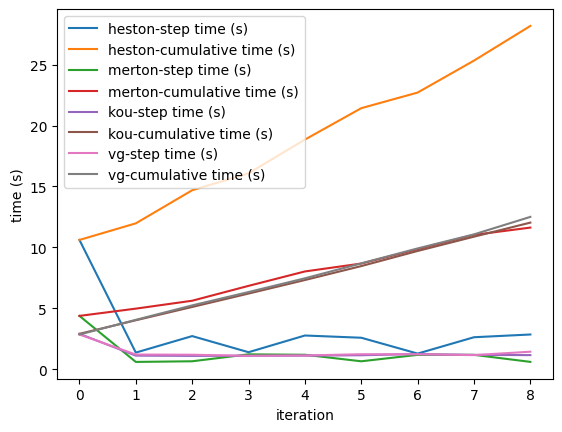

In [73]:
stats = {
    'heston'    : heston_stat,
    'merton'    : merton_stat,
    'kou'       : kou_stat,
    'vg'        : vg_stat
}

for model_name, time_stat in stats.items():
    plot_time_stat(model_name, time_stat)

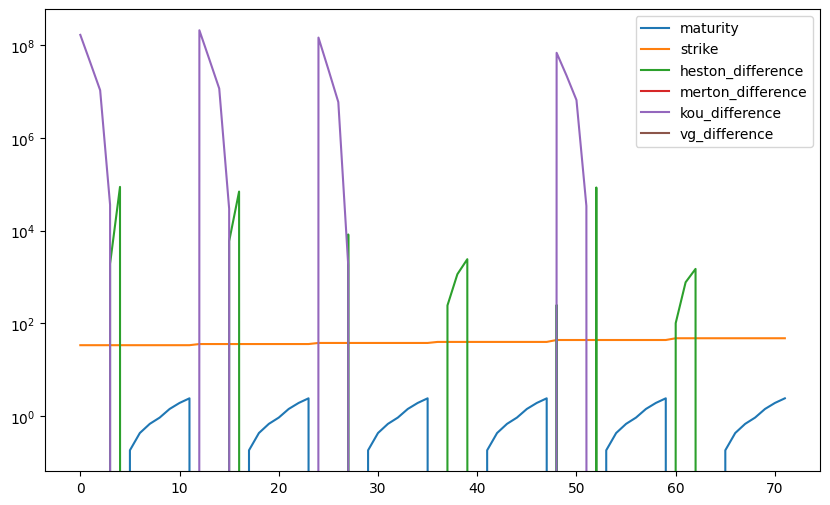

In [68]:
vol_surface_long[['maturity', 'strike', 'heston_difference', 'merton_difference', 'kou_difference', 'vg_difference']].plot.line(figsize=(10, 6))
plt.yscale('log')